## Example of looking at high rate event data from a strainmeter

In [1]:
import numpy as np
import pandas as pd
import math
from earthscopestraintools.mseed_tools import ts_from_mseed
from earthscopestraintools.gtsm_metadata import GtsmMetadata
from earthscopestraintools.timeseries import Timeseries
from earthscopestraintools.event import Earthquake
from earthscopestraintools.event_processing import calc_hypocentral_dist, magnitude_plot, plot_coseismic_offset
from datetime import datetime, timedelta

import logging
logger = logging.getLogger()
logging.basicConfig(
        format="%(message)s", level=logging.INFO
    )

In [2]:
network = 'IV'
station = 'TSM3'
meta = GtsmMetadata(network,station)

### Load event data based on USGS event_id

In [3]:
eq = Earthquake(event_id = "us7000jiky")
hypocentral_distance = calc_hypocentral_dist(eq.lat,
                                                 eq.long,
                                                 eq.depth,
                                                 meta.latitude,
                                                 meta.longitude)
print(f"USGS Magnitude {eq.mag} at {hypocentral_distance} km at {eq.time}") 
meta.get_event_terms()

USGS Magnitude 4.5 at 15 km at 2023-03-09 19:08:07.123000+00:00


### Load raw strain data

IV TSM3 Loading T0 BS* from 2023-03-09T19:07:52 to 2023-03-09T19:09:07 from Earthscope DMC miniseed
    Trace 1. 2023-03-09T19:07:52.000000Z:2023-03-09T19:09:07.000000Z mapping BS1 to CH0
    Trace 2. 2023-03-09T19:07:52.000000Z:2023-03-09T19:09:07.000000Z mapping BS2 to CH1
    Trace 3. 2023-03-09T19:07:52.000000Z:2023-03-09T19:09:07.000000Z mapping BS3 to CH2
    Trace 4. 2023-03-09T19:07:52.000000Z:2023-03-09T19:09:07.000000Z mapping BS4 to CH3
    Found 0 epochs with nans, 17.75 epochs with 999999s, and 0 missing epochs.
    Total missing data is 1.18%
  Converting 999999 gap fill values to nan
    Found 17 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 1.13%
IV.TSM3.T0.BS*
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series:         raw| Units:        counts| Level:          0| Gaps:            1.13% 
    | Epochs:        1501| G

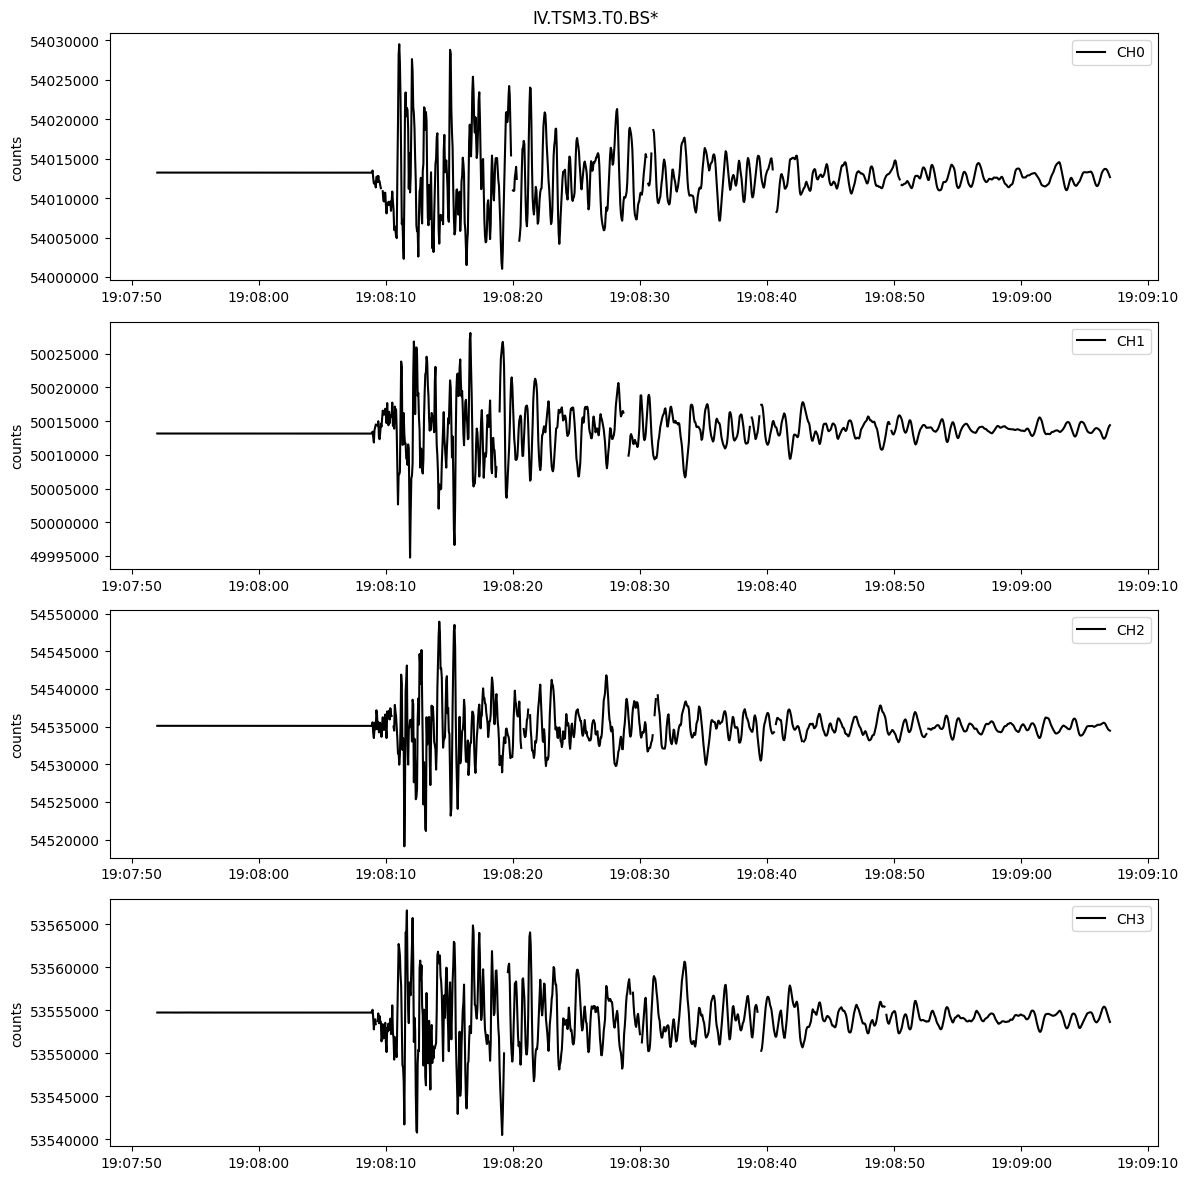

In [4]:
start = (eq.time - timedelta(seconds=15)).strftime("%Y-%m-%dT%H:%M:%S")
end = (eq.time + timedelta(seconds=60)).strftime("%Y-%m-%dT%H:%M:%S")
strain_raw = ts_from_mseed(network=network, station=station, location='T0', channel='BS*', start=start, end=end)
strain_raw.stats()
strain_raw.plot(type='line')

### Convert counts to microstrain

In [5]:
gauge_microstrain = strain_raw.linearize(reference_strains=meta.reference_strains, gap=meta.gap)
gauge_microstrain.stats()


Converting raw counts to microstrain
    Found 17 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 1.13%
IV.TSM3.T0.BS*.linearized
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series: microstrain| Units:   microstrain| Level:          1| Gaps:            1.13% 
    | Epochs:        1501| Good:        1483.25| Missing:    17.75| Interpolated:      0.0
    | Samples:       6004| Good:           5933| Missing:       71| Interpolated:        0


### Interpolate and high pass filter (1000s cutoff)

In [6]:
gauge_microstrain_interpolated = gauge_microstrain.interpolate(method='linear', limit_seconds=3600)
gauge_microstrain_interpolated.stats()


Interpolating data using method=linear and limit=72000
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM3.T0.BS*.linearized.interpolated
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series: microstrain| Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        1501| Good:        1483.25| Missing:      0.0| Interpolated:    17.75
    | Samples:       6004| Good:           5933| Missing:        0| Interpolated:       71


Applying Butterworth Filter


    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM3.T0.BS*.linearized.interpolated.filtered
    | Channels: ['CH0', 'CH1', 'CH2', 'CH3']             
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series:            | Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        1501| Good:        1483.25| Missing:      0.0| Interpolated:    17.75
    | Samples:       6004| Good:           5933| Missing:        0| Interpolated:       71


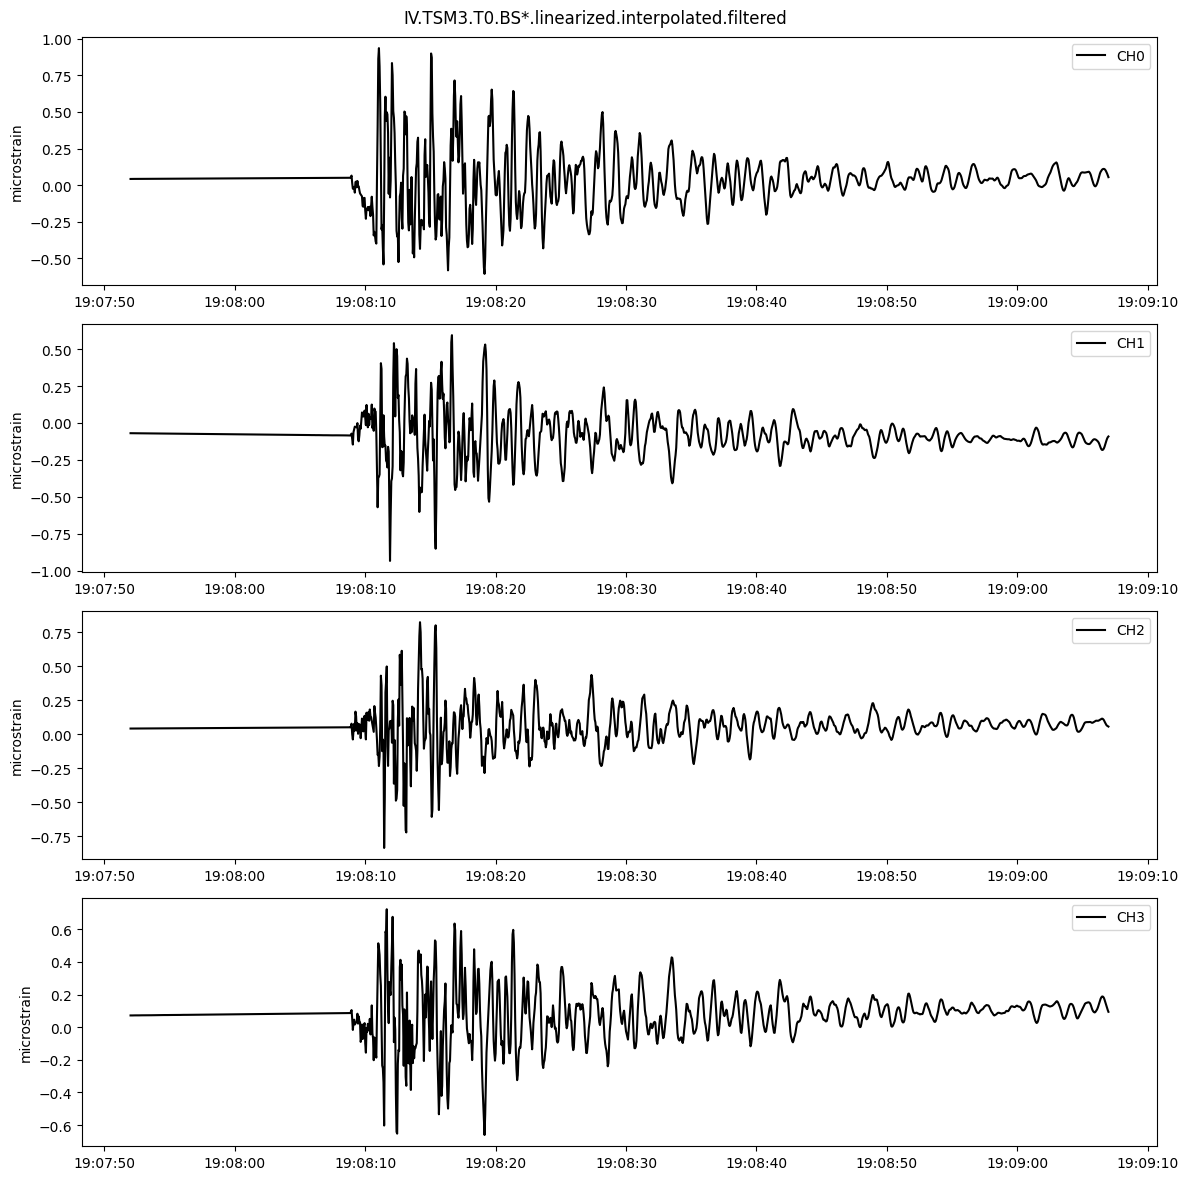

In [7]:
gauge_microstrain_filtered = gauge_microstrain_interpolated.butterworth_filter(filter_type='high', filter_order=2, filter_cutoff_s=1000)
gauge_microstrain_filtered.stats()
gauge_microstrain_filtered.plot(type='line')

### Calculate dynamic strain and estimated magnitude using Barbour et al 2021

Calculating dynamic strain using gauge weights: [1, 1, 1, 1]
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%
IV.TSM3.T0.BS*.linearized.interpolated.filtered.dynamic
    | Channels: ['dynamic']                              
    | TimeRange: 2023-03-09 19:07:52 - 2023-03-09 19:09:07        | Period:          0.05s
    | Series:     dynamic| Units:   microstrain| Level:          1| Gaps:             0.0% 
    | Epochs:        1501| Good:         1435.0| Missing:      0.0| Interpolated:     66.0
    | Samples:       1501| Good:           1435| Missing:        0| Interpolated:       66


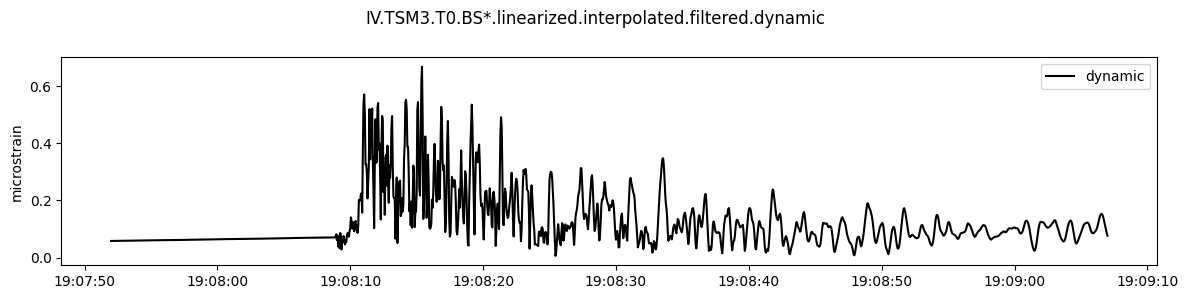

In [8]:
dynamic_strain = gauge_microstrain_filtered.dynamic_strain()
dynamic_strain.stats()
dynamic_strain.plot(type='line')

Calculating magnitude from dynamic strain using site term 0 and longitude term 0
    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


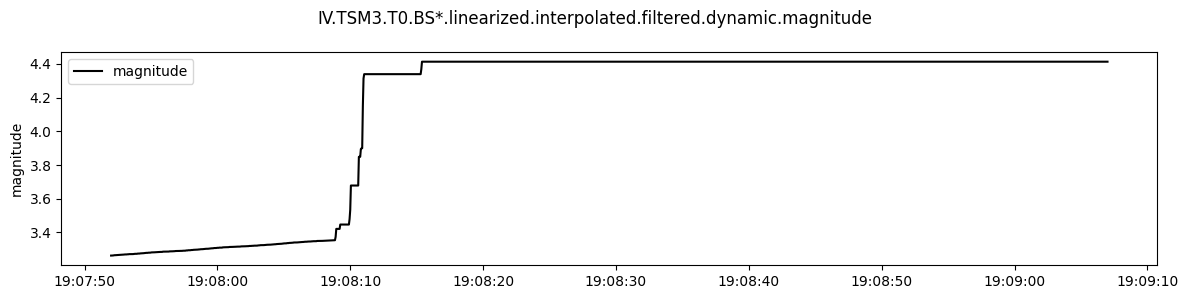

In [9]:
estimated_magnitude = dynamic_strain.calculate_magnitude(hypocentral_distance, meta.site_term, meta.longitude_term)
estimated_magnitude.plot()

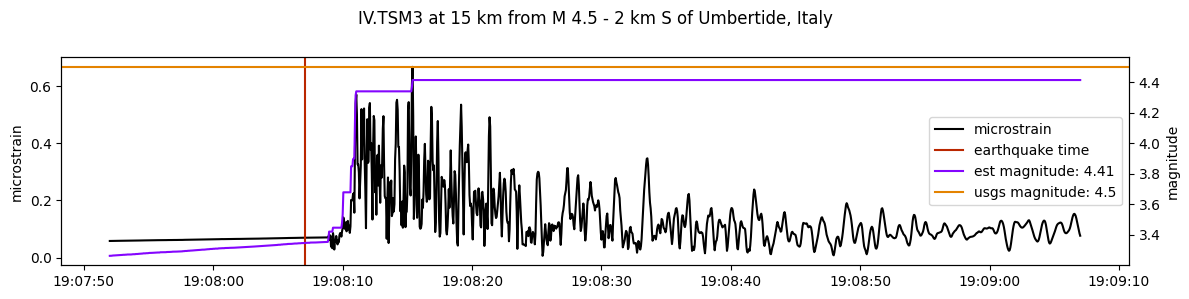

In [10]:
title = f"{network}.{station} at {hypocentral_distance} km from {eq.name}"
magnitude_plot(dynamic_strain_df=dynamic_strain.data, 
               magnitude_df=estimated_magnitude.data, 
               eq_time=eq.time, 
               eq_mag=eq.mag, 
               title=title)

### Plot any co-seismic offsets in regional strains

Applying None matrix:
 [[ 0.2962963   0.51851852  0.2962963   0.22222222]
 [ 0.16507151  0.30039401 -0.28522912 -0.1802364 ]
 [-0.35550881  0.21665099  0.26884841 -0.12999059]]


    Found 0 epochs with nans, 0.0 epochs with 999999s, and 0 missing epochs.
    Total missing data is 0.0%


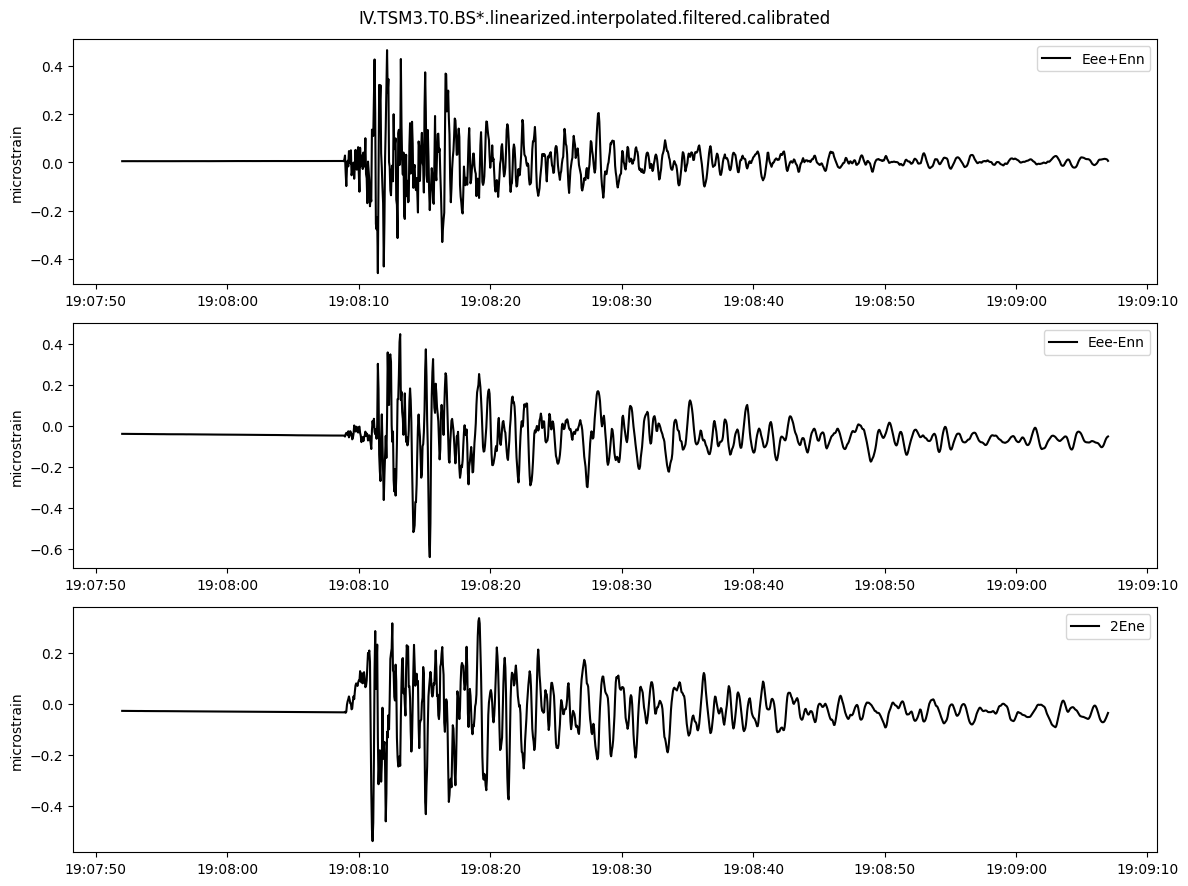

In [11]:
regional_microstrain = gauge_microstrain_filtered.apply_calibration_matrix(meta.strain_matrices['lab'])
regional_microstrain.plot()

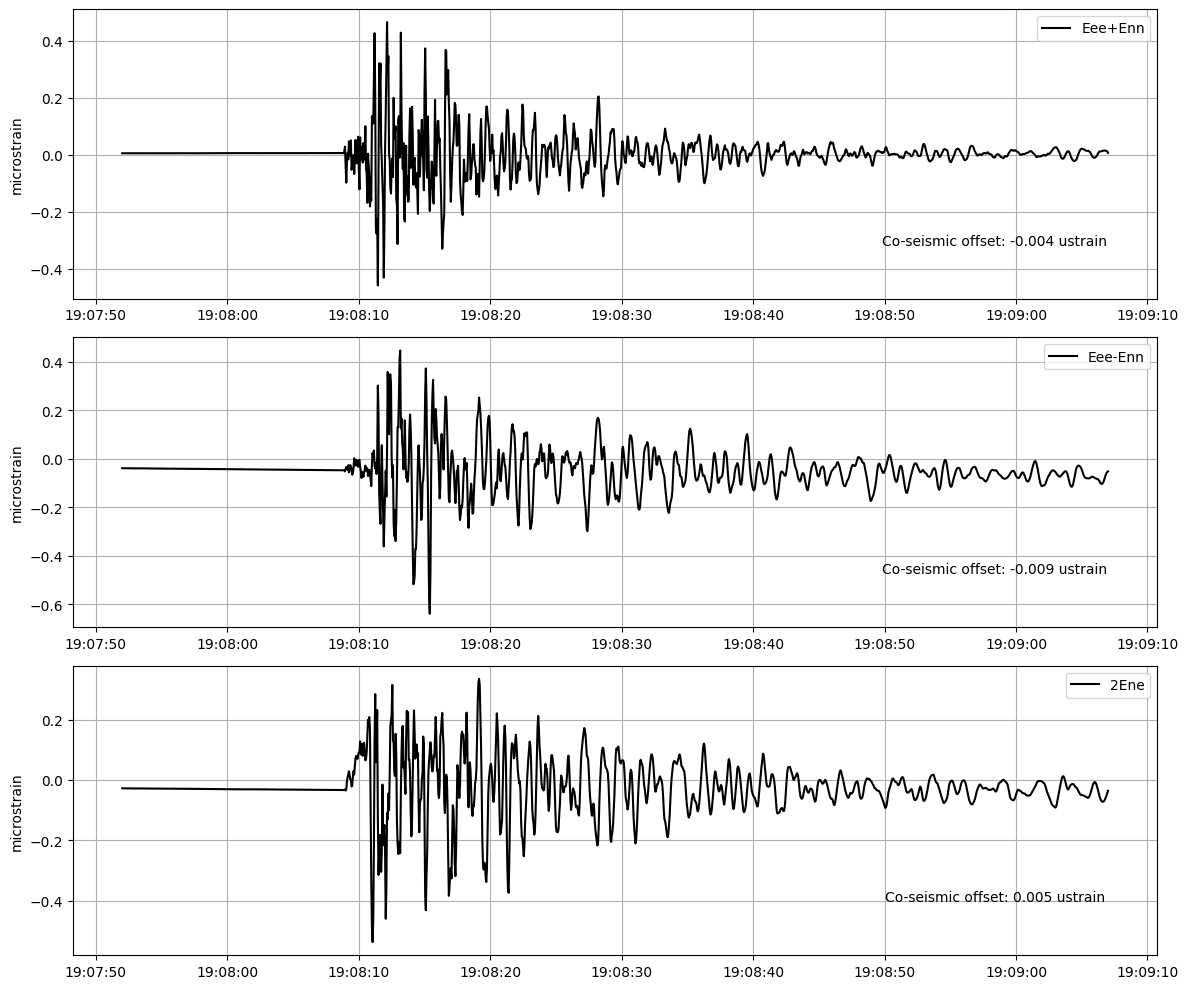

In [12]:
plot_coseismic_offset(
    df = regional_microstrain.data,
    plot_type='line',
    units = 'microstrain',
    eq_time= eq.time,
    coseismic_offset = True,
    color="black",)
    